In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

#load data
column_names = [
    "sex",
    "length",
    "diameter",
    "height",
    "whole_weight",
    "shucked_weight",
    "viscera_weight",
    "shell_weight",
    "rings"
] 
df = pd.read_csv("data/abalone.data", names=column_names)

In [3]:
#remove data as discussed in project 1
print(len(df))
df = df[df['height'] != 0]
print(len(df))
df = df[df['height'] < 0.4]
print(len(df))
df = df[(df["whole_weight"] - df["shucked_weight"] - df["viscera_weight"] - df["shell_weight"]) > 0]  
print(len(df))

4177
4175
4173
4016


In [4]:
y = df["rings"]
X = df.drop(columns=["rings"])
X = pd.get_dummies(X, columns=['sex', ])

In [5]:
#split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

In [7]:
#normalise data
numerical_columns = X.select_dtypes("number").columns
mean = X_train[numerical_columns].mean(axis=0)
std = X_train[numerical_columns].std(axis=0)
X_train[numerical_columns] = (X_train[numerical_columns] - mean[numerical_columns]) / std[numerical_columns]
X_test[numerical_columns] = (X_test[numerical_columns] - mean[numerical_columns]) / std[numerical_columns]

The task is a bit senseless for our dataset, as parameter optimisation in this case is to combat overfitting. Our model does not overfit at all though.

<Axes: xlabel='alpha'>

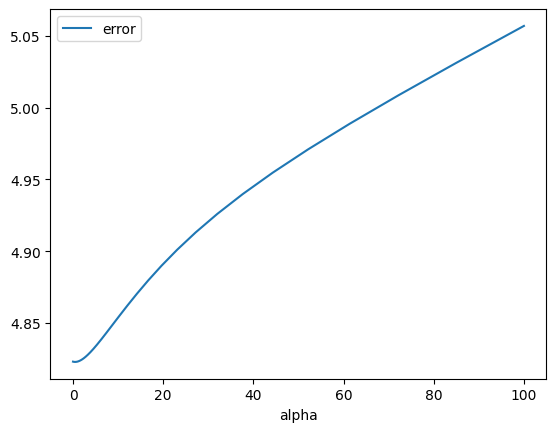

In [8]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score 
import numpy as np

def cross_validation(alpha):
    k = 10
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    model = Ridge(alpha)
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    return abs(scores.mean())

r_alphas = np.logspace(-5, 2, 100)# initiate the cross validation over alphas
performance = []
for a in r_alphas:
    performance.append({"alpha": a, "error": cross_validation(a)})

d = pd.DataFrame(performance)
d.plot( 'alpha' , 'error' )



In [9]:
model = Ridge(alpha=0.1)
model.fit(X_train, y_train)
coefficients = model.coef_
intercept = model.intercept_

print(coefficients)
print(intercept)
X_train.head()


[-0.1989312   0.90577108  0.89922313  5.31892182 -4.82584779 -1.459709
  0.8640796   0.26448208 -0.57313999  0.3086579 ]
9.966532270402203


,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,sex_F,sex_I,sex_M
4172,0.317322,0.401792,0.655953,0.093682,0.030559,0.515571,0.053908,True,False,False
1195,1.501890,1.424421,0.788073,0.772614,1.252074,0.488177,0.429060,True,False,False
3365,-0.740329,-1.029887,-0.665249,-0.978906,-1.039116,-0.918038,-0.876755,False,True,False
445,0.275016,0.452924,1.316553,-0.260098,-0.363770,-0.488868,0.241484,True,False,False
1952,0.951912,0.810844,-0.136768,0.529262,0.565397,0.620581,0.367737,False,True,False


In [10]:
model = Ridge(alpha=0.0000000000000000000001).fit(X_train, y_train)
print(f"Linear Regression-Training set score: {model.score(X_train, y_train):.2f}")
print(f"Linear Regression-Test set score: {model.score(X_test, y_test):.2f}")

Linear Regression-Training set score: 0.55
Linear Regression-Test set score: 0.52


/home/malte/Documents/machine_learning/excercises/abalone2/machine_learning/.venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=8.26321e-18): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


In [11]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(X_train, y_train)

print(f"Linear Regression-Training set score: {lr.score(X_train, y_train):.2f}")
print(f"Linear Regression-Test set score: {lr.score(X_test, y_test):.2f}")

Linear Regression-Training set score: 0.55
Linear Regression-Test set score: 0.52


This also holds in general: When the regularization λ is small, the models have high variance
and low bias. When λ is large, the models have low variance (they are all dragged towards the
x-axis) but high bias. As a rule, varying λ to search for an optimal value of the generalization error
will therefore lead to better models. In fig. 14.3 the variable λ is tweaked from a very small value
of λ = 10−6 to a higher value λ = 100 and the training and test error (normalized by the number
of observations) of the small dataset in fig. 14.1 displayed. The three particular values plotted in
fig. 14.1 are plotted as circles. We see that the training error generally increases as λ increases (after
all, for small λ the model will overfit the training data set), however, the test error has an optimum
when λ ≈ 10−2. In practice when we search for the optimal value of λ, we test S different values
of λ, λ1, . . . , λS selected beforehand and then compare each of the corresponding linear regression
models using cross-validation for model selection.

In [42]:
print(y)

0       15
1        7
2        9
3       10
4        7
        ..
4172    11
4173    10
4174     9
4175    10
4176    12
Name: rings, Length: 4016, dtype: int64


In [64]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
def grid_search(X, y, model, inner_cv, param_grid=None):
    gs = GridSearchCV(
        estimator=model, param_grid=param_grid, cv=inner_cv, n_jobs=2
    )
    best_model = gs.fit(X, y)
    return gs.best_params_, best_model

def calculate_mse(X, y, model):  
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    return mse

outer_cv = KFold(n_splits=10, shuffle=True, random_state=1)
inner_cv = KFold(n_splits=10, shuffle=True, random_state=1)


def cross_validation_baseline(y_train, y_test):
    linear_regression_model = LinearRegression(fit_intercept=True)
    linear_regression_model.fit(X=np.zeros((len(y_train), 1)), y=y_train)
    X = np.zeros((len(y_test), 1))
    return calculate_mse(X, y_test, linear_regression_model)
    

baseline_scores = []
linear_regression_scores = []
ann_scores = []
ann_param_grid = {
    'hidden_layer_sizes': [(h,) for h in range(5, 105, 10)]  
}
ridge_grid = {
    'alpha': np.logspace(-5, 2, 100)
}
for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X), 1):
    X_train = X.iloc[train_idx]
    X_test = X.iloc[test_idx]
    y_train = y.iloc[train_idx]
    y_test = y.iloc[test_idx]
    
    linear_regression_model = Ridge()

    baseline_scores.append({"fold": fold, "error": cross_validation_baseline(y_train, y_test)})
    best_params, best_model = grid_search(X_train, y_train, linear_regression_model, inner_cv, ridge_grid)
    linear_regression_scores.append({"fold": fold, "alpha": best_params["alpha"], "error": calculate_mse(X_train, y_train, best_model)})

    ann_model = MLPRegressor(max_iter=1000, random_state=1)
    best_ann_params, best_ann_model = grid_search(X_train, y_train, ann_model, inner_cv, ann_param_grid)
    ann_scores.append({
        "fold": fold,
        "hidden_layer_sizes": best_ann_params["hidden_layer_sizes"],
        "error": calculate_mse(X_test, y_test, best_ann_model)
    })

print(f"linear_regression_scores: {linear_regression_scores}")
print(f"baseline_scores: {baseline_scores}")
print(f"ann_scores: {ann_scores}")












    

/home/malte/Documents/machine_learning/excercises/abalone2/machine_learning/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


linear_regression_scores: [{'fold': 1, 'alpha': np.float64(0.05590810182512223), 'error': 4.6909219504994635}, {'fold': 2, 'alpha': np.float64(0.040370172585965536), 'error': 4.82249634761566}, {'fold': 3, 'alpha': np.float64(0.10722672220103231), 'error': 4.705752574383518}, {'fold': 4, 'alpha': np.float64(0.06579332246575675), 'error': 4.716782000257832}, {'fold': 5, 'alpha': np.float64(0.047508101621027934), 'error': 4.741400530295358}, {'fold': 6, 'alpha': np.float64(0.029150530628251757), 'error': 4.8679793662435}, {'fold': 7, 'alpha': np.float64(0.05590810182512223), 'error': 4.641218019038885}, {'fold': 8, 'alpha': np.float64(0.047508101621027934), 'error': 4.726187272567212}, {'fold': 9, 'alpha': np.float64(0.1261856883066021), 'error': 4.764483308743207}, {'fold': 10, 'alpha': np.float64(0.047508101621027934), 'error': 4.774017962715395}]
baseline_scores: [{'fold': 1, 'error': 10.977558181817649}, {'fold': 2, 'error': 8.98924895328737}, {'fold': 3, 'error': 10.495731901539866}

In [65]:
df_baseline = pd.DataFrame(baseline_scores).set_index("fold")
df_lr = pd.DataFrame(linear_regression_scores).set_index("fold")
df_ann = pd.DataFrame(ann_scores).set_index("fold")

df = pd.DataFrame({
    "h_i*": [x[0] for x in df_ann["hidden_layer_sizes"]],
    "E_i^test (ANN)": df_ann["error"],
    "λ_i*": df_lr["alpha"],
    "E_i^test (LR)": df_lr["error"],
    "E_i^test (baseline)": df_baseline["error"]
})

latex_table = r"""\begin{table}[h]
\centering
\begin{tabular}{c c c c c c}
\toprule
Outer fold & \multicolumn{2}{c}{ANN} & \multicolumn{2}{c}{Linear regression} & baseline \\
\cmidrule(lr){2-3} \cmidrule(lr){4-5}
$i$ & $h_i^*$ & $E_i^{\text{test}}$ & $\lambda_i^*$ & $E_i^{\text{test}}$ & $E_i^{\text{test}}$ \\
\midrule
"""

for i, row in df.iterrows():
    latex_table += f"{i} & {row['h_i*']} & {row['E_i^test (ANN)']:.2f} & {row['λ_i*']:.2g} & {row['E_i^test (LR)']:.2f} & {row['E_i^test (baseline)']:.2f} \\\\\n"

latex_table += r"""\bottomrule
\end{tabular}
\end{table}
"""

print(latex_table)


\begin{table}[h]
\centering
\begin{tabular}{c c c c c c}
\toprule
Outer fold & \multicolumn{2}{c}{ANN} & \multicolumn{2}{c}{Linear regression} & baseline \\
\cmidrule(lr){2-3} \cmidrule(lr){4-5}
$i$ & $h_i^*$ & $E_i^{\text{test}}$ & $\lambda_i^*$ & $E_i^{\text{test}}$ & $E_i^{\text{test}}$ \\
\midrule
1 & 75.0 & 5.14 & 0.056 & 4.69 & 10.98 \\
2 & 75.0 & 3.80 & 0.04 & 4.82 & 8.99 \\
3 & 75.0 & 5.01 & 0.11 & 4.71 & 10.50 \\
4 & 75.0 & 4.72 & 0.066 & 4.72 & 10.16 \\
5 & 75.0 & 4.59 & 0.048 & 4.74 & 11.24 \\
6 & 75.0 & 3.46 & 0.029 & 4.87 & 7.96 \\
7 & 75.0 & 5.43 & 0.056 & 4.64 & 11.96 \\
8 & 75.0 & 4.45 & 0.048 & 4.73 & 11.44 \\
9 & 75.0 & 4.46 & 0.13 & 4.76 & 10.19 \\
10 & 75.0 & 4.19 & 0.048 & 4.77 & 10.42 \\
\bottomrule
\end{tabular}
\end{table}



In [70]:
df



,h_i*,E_i^test (ANN),λ_i*,E_i^test (LR),E_i^test (baseline)
Outer fold,,,,,
1,75,5.143986,0.055908,4.690922,10.977558
2,75,3.803982,0.040370,4.822496,8.989249
3,75,5.006049,0.107227,4.705753,10.495732
4,75,4.722446,0.065793,4.716782,10.164654
5,75,4.591535,0.047508,4.741401,11.243693
6,75,3.455044,0.029151,4.867979,7.963385
7,75,5.433169,0.055908,4.641218,11.961445
8,75,4.448849,0.047508,4.726187,11.437400
9,75,4.458187,0.126186,4.764483,10.191917
